Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
DATA = "bin"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8
PATH = "m.pth"
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms

from src.functions import *
from src.dataset import *
from src.train import *


print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
# seed_everything(42)
"seed_everything(42)"

'seed_everything(42)'

# torchvision.transforms

In [5]:
# data_transform = transforms.Compose([
#     # transforms.Resize(size=(224, 224)),
#     transforms.RandomCrop(300),
#     # Flip the images randomly on the horizontal
#     # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
#     # Turn the image into a torch.Tensor
#     transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
# ])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [6]:
# files_names = sorted(os.listdir(IMG_POS))
# image_paths  = [os.path.join(IMG_POS, i) for i in files_names]

# plot_transformed_images(image_paths, transform=data_transform)

# Dataset

In [7]:
class Positive_Dataset(Dataset):
    def __init__(
        self, images_dir, augmentation, transform, deterministic=True, seed=42
    ):
        self.augmentation = augmentation
        self.transform = transform
        self.deterministic = deterministic

        self.files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in self.files_names]

        self.real_len = len(self.files_names)
        self.required_len = self.augmentation * self.real_len

        if self.deterministic:
            seed_everything(seed)
            self.X = []

            # for i in range(self.required_len):
            i = 0
            while len(self.X) < self.required_len:
                image = Image.open(self.image_paths[i % self.real_len])
                i += 1
                transformed_image = self.transform(image)

                x, col = np.unique(transformed_image.max(dim = 0)[0], return_counts = True)
                ones = col[np.where(x == 1)[0]][0]
                dol = ones / col.sum() # доля белого
                if dol < 0.99:
                    self.X.append((transformed_image, 1))

    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                image = Image.open(self.image_paths[idx % self.real_len])
                return self.transform(image), 1
        else:
            raise IndexError


class Negative_Dataset(Dataset):
    def __init__(
        self, images_dir, augmentation, transform, deterministic=True, seed=42
    ):
        self.augmentation = augmentation
        self.transform = transform
        self.deterministic = deterministic

        self.files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in self.files_names]

        self.real_len = len(self.files_names)
        self.required_len = self.augmentation * self.real_len

        if self.deterministic:
            seed_everything(seed)
            self.X = []

            # for i in range(self.required_len):
            i = 0
            while len(self.X) < self.required_len:
                image = Image.open(self.image_paths[i % self.real_len])
                i += 1
                image = Image.open(self.image_paths[i % self.real_len])
                transformed_image = self.transform(image)

                x, col = np.unique(transformed_image.max(dim = 0)[0], return_counts = True)
                ones = col[np.where(x == 1)[0]][0]
                dol = ones / col.sum() # доля белого
                if dol < 0.99:
                    self.X.append((transformed_image, 0))

    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                image = Image.open(self.image_paths[idx % self.real_len])
                return self.transform(image), 0
        else:
            raise IndexError

In [8]:
data_transform = transforms.Compose([
    transforms.RandomCrop(300),
    transforms.ToTensor()
])

pos_dataset = Positive_Dataset(DATA_POS, augmentation=11, transform=data_transform)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = Negative_Dataset(DATA_NEG, augmentation=1, transform=data_transform)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

Positive: 242    (22)
Negative: 224    (224)
ConcatDataset: 466


In [9]:
# seed_everything(42)

# n = []

# l = len(pos_dataset.files_names)
# for i, (img, cl) in enumerate(pos_dataset):
#     fname = pos_dataset.files_names[i % l]
#     file, ext = os.path.splitext(fname)
#     # print(fname)
#     n.append(f"{file}_{i // l}{ext}")
#     # print(f"{file}#{i // l}{ext}\n")
#     # img.save(os.path.join(DATA_POS, f"{file}#{i // l}{ext}"))

In [10]:
# в тренировочную выборку отнесем 80% всех картинок

train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

seed_everything(42)
train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 372
 Test: 94


# Dataloader

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 47
 Test batches: 12


In [12]:
pos_neg(train_loader)

{'1': 200, '0': 172, 'total': 372}

In [13]:
pos_neg(test_loader)

{'1': 42, '0': 52, 'total': 94}

torch.Size([8, 3, 300, 300]) tensor([0, 1, 1, 0, 0, 0, 0, 1])


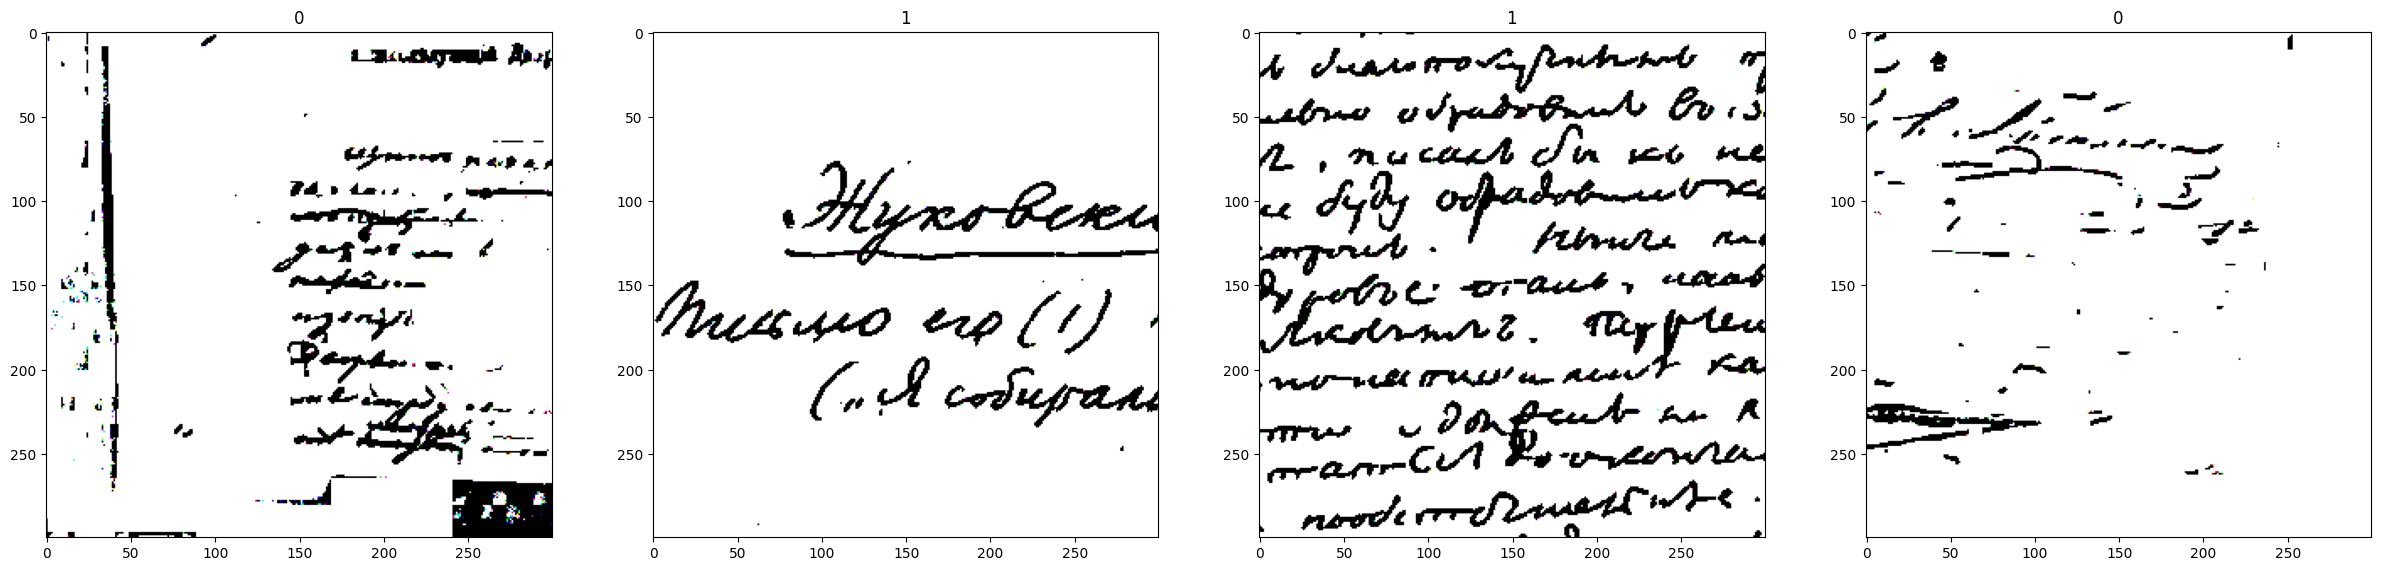

In [14]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_images(images, labels)

# freeze_layers

In [15]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


In [16]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [17]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

seed_everything(42)
model = create_model(model, num_layers - 1, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 2


In [18]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [19]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# train

In [20]:
%time

seed_everything(42)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=20)
torch.save(model.state_dict(), PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
Epoch: 1
Эпоха 1/20: val лосс и accuracy: 0.6480601330598196 0.59574467
Epoch: 2
Эпоха 2/20: val лосс и accuracy: 0.6533443679412206 0.5851064
Epoch: 3
Эпоха 3/20: val лосс и accuracy: 0.6318584134181341 0.63829786
Epoch: 4
Эпоха 4/20: val лосс и accuracy: 0.6085799882809321 0.67021275
Epoch: 5
Эпоха 5/20: val лосс и accuracy: 0.5885537912448248 0.69148934
Epoch: 6
Эпоха 6/20: val лосс и accuracy: 0.5711237688859304 0.71276593
Epoch: 7
Эпоха 7/20: val лосс и accuracy: 0.5557743261257807 0.7340425
Epoch: 8
Эпоха 8/20: val лосс и accuracy: 0.5421172007918358 0.7765958
Epoch: 9
Эпоха 9/20: val лосс и accuracy: 0.5298587555686632 0.78723407
Epoch: 10
Эпоха 10/20: val лосс и accuracy: 0.5187744870781898 0.80851066
Epoch: 11
Эпоха 11/20: val лосс и accuracy: 0.508689726392428 0.81914896
Epoch: 12
Эпоха 12/20: val лосс и accuracy: 0.4994662379225095 0.81914896
Epoch: 13
Эпоха 13/20: val лосс и accuracy: 0.49099261313676834 0.8297

In [21]:
# CPU times: user 3 µs, sys: 0 ns, total: 3 µs
# Wall time: 6.91 µs
# Epoch: 1
# Эпоха 1/20: val лосс и accuracy: 0.672874982158343 0.63829786
# Epoch: 2
# Эпоха 2/20: val лосс и accuracy: 0.6797899454832077 0.5531915
# Epoch: 3
# Эпоха 3/20: val лосс и accuracy: 0.6637554814418157 0.5744681
# Epoch: 4
# Эпоха 4/20: val лосс и accuracy: 0.6459873616695404 0.63829786
# Epoch: 5
# Эпоха 5/20: val лосс и accuracy: 0.6305517305930456 0.65957445
# Epoch: 6
# Эпоха 6/20: val лосс и accuracy: 0.6169861008723577 0.68085104
# Epoch: 7
# Эпоха 7/20: val лосс и accuracy: 0.6049200817942619 0.69148934
# Epoch: 8
# Эпоха 8/20: val лосс и accuracy: 0.5940680305163065 0.70212764
# Epoch: 9
# Эпоха 9/20: val лосс и accuracy: 0.5842111011346182 0.70212764
# Epoch: 10
# Эпоха 10/20: val лосс и accuracy: 0.5751814246177673 0.7446808
# Epoch: 11
# Эпоха 11/20: val лосс и accuracy: 0.566849393149217 0.7553192
# Epoch: 12
# Эпоха 12/20: val лосс и accuracy: 0.5591137508551279 0.7659575
# Epoch: 13
# Эпоха 13/20: val лосс и accuracy: 0.5518945703903834 0.7765958
# Epoch: 14
# Эпоха 14/20: val лосс и accuracy: 0.5451276873548826 0.78723407
# Epoch: 15
# Эпоха 15/20: val лосс и accuracy: 0.5387609650691351 0.79787236
# Epoch: 16
# Эпоха 16/20: val лосс и accuracy: 0.5327514261007309 0.79787236
# Epoch: 17
# Эпоха 17/20: val лосс и accuracy: 0.5270631661017736 0.79787236
# Epoch: 18
# Эпоха 18/20: val лосс и accuracy: 0.5216657693187395 0.78723407
# Epoch: 19
# Эпоха 19/20: val лосс и accuracy: 0.5165332555770874 0.78723407
# Epoch: 20
# Эпоха 20/20: val лосс и accuracy: 0.511643206079801 0.79787236

# Код визуализации

In [22]:
def show_images(images, labels, n = 4):
    # f, axes= plt.subplots(n//4, 4, figsize=(30,10))


    num_pic = min(len(images), n)
    width, height = 4, num_pic // 4 + 1

    # plt.figure(figsize=(6.4 * width, 6))

    for i in range(num_pic):

        if i % width == 0:
            plt.figure(figsize=(6.4 * width, 6))

        # plt.subplot(height, width, i + 1)
        plt.subplot(1, width, i % width + 1)

        img = images[i]
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img)
        if torch.is_tensor(labels[i]):
            title = labels[i].numpy()
        else:
            title = labels[i]

        x, col = np.unique(img.max(dim = 2)[0], return_counts = True)
        ones = col[np.where(x == 1)[0]][0]
        dol = ones / col.sum()
        title = f"{title:.6} (доля белого - {dol:.4})"
        plt.title(title)

        if i % width == width - 1:
            plt.tight_layout()
            plt.show()

    plt.show()

In [23]:
def show_result(model, dataset, threshold, greater = True, col = 8, seed = 42, sort = False):
    seed_everything(seed)

    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

    y_pred, y_true, y_prob, X = get_predictions(model, loader)

    if sort:
        s, indices = torch.sort(y_prob, descending=True)
        y_pred = y_pred[indices]
        y_prob = y_prob[indices]
        X = X[indices]

    if greater:
        idx = np.where(y_prob > threshold)[0]
    else:
        idx = np.where(y_prob < threshold)[0]


    sign = ">" if greater else "<"
    print(f"prob {sign} {threshold}\ncount : {len(idx)} out of {len(dataset)}")
    idx = idx[:col]
    print(f"pic idx : {list(idx)}")
    show_images(X[idx], y_prob[idx], n = col)

    return y_pred, y_true, y_prob, X

# eval

In [24]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)
# 0.8172043010752689

0.8440860215053764

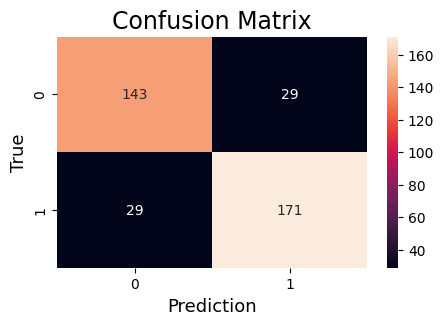

array([[143,  29],
       [ 29, 171]])

In [25]:
confusion_matrix(y_true, y_pred)

In [26]:
y_pred, y_true, y_prob, _ = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)
# 0.7978723404255319

0.8404255319148937

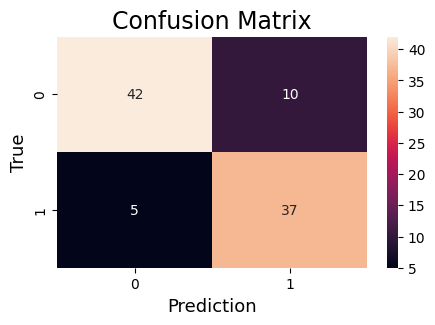

array([[42, 10],
       [ 5, 37]])

In [27]:
confusion_matrix(y_true, y_pred)

# show

0.859504132231405


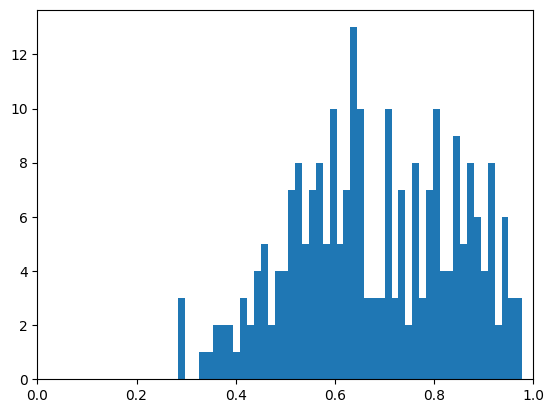

In [28]:
pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
print(accuracy_score(y_pred, y_true))

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.7975206611570248

0.8258928571428571


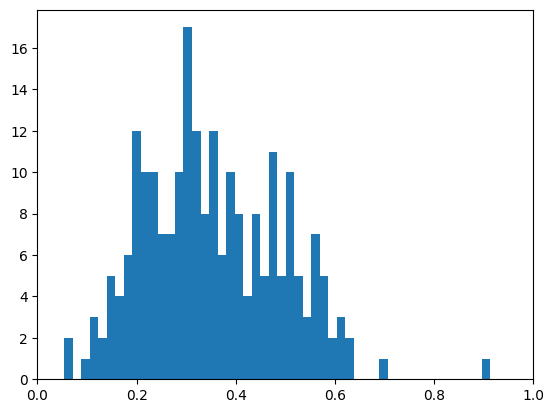

In [29]:
neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, neg_loader)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.8303571428571429

prob > 0.8
count : 69 out of 242
pic idx : [0, 4, 5, 6, 7, 8, 15, 26]


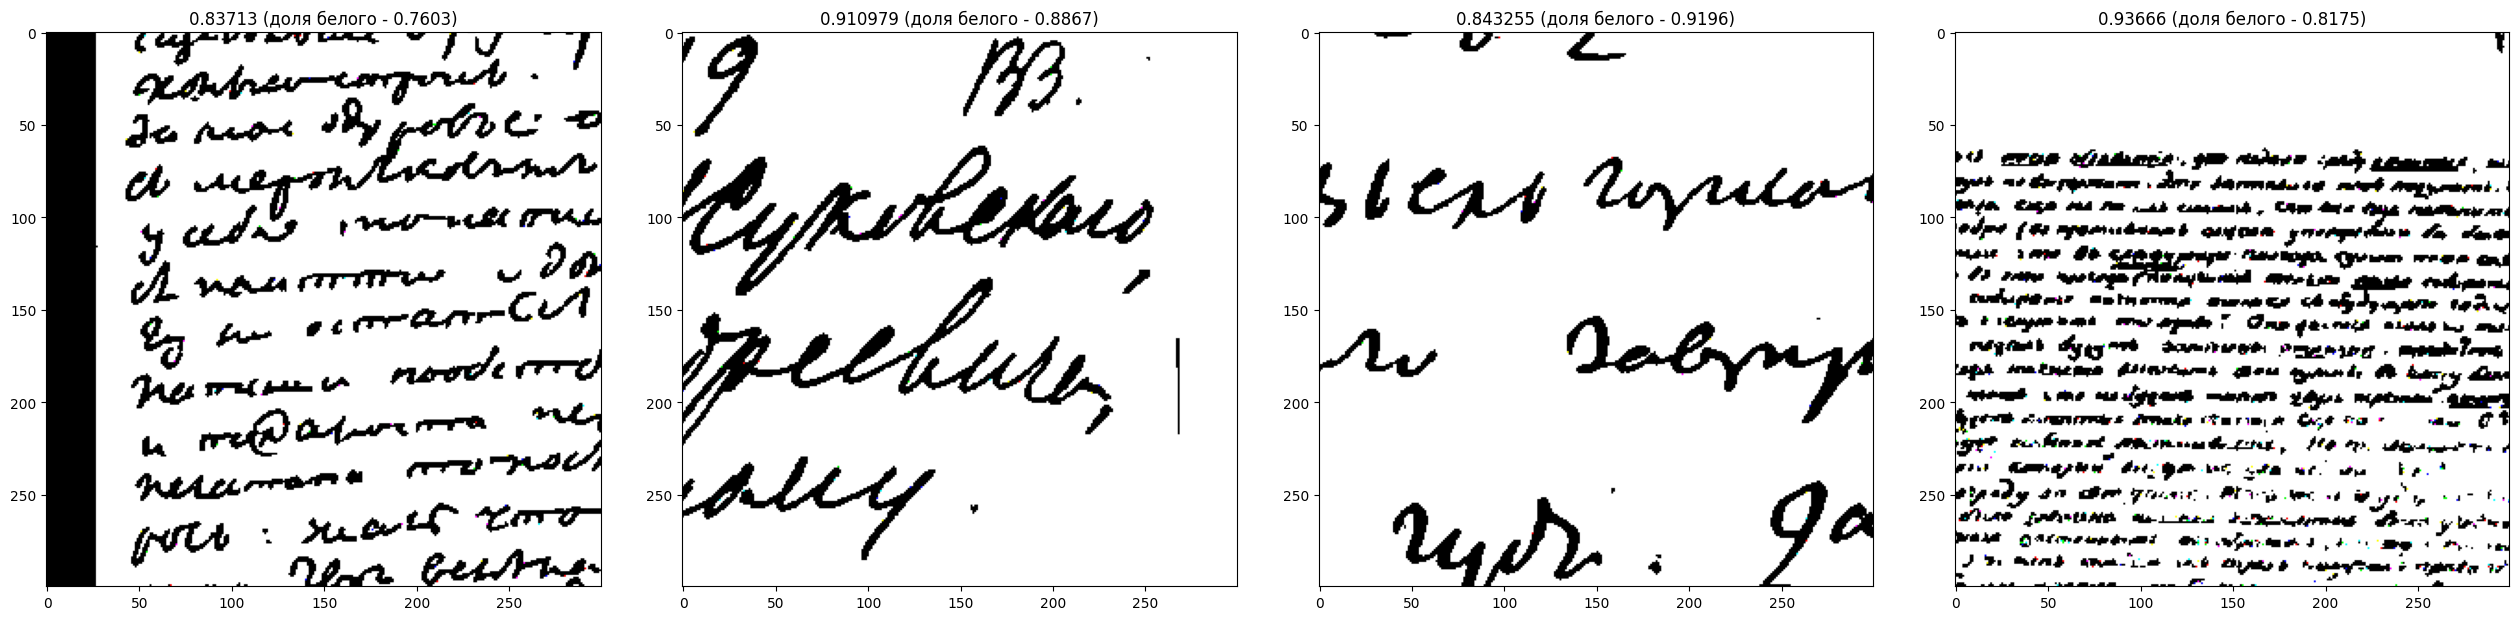

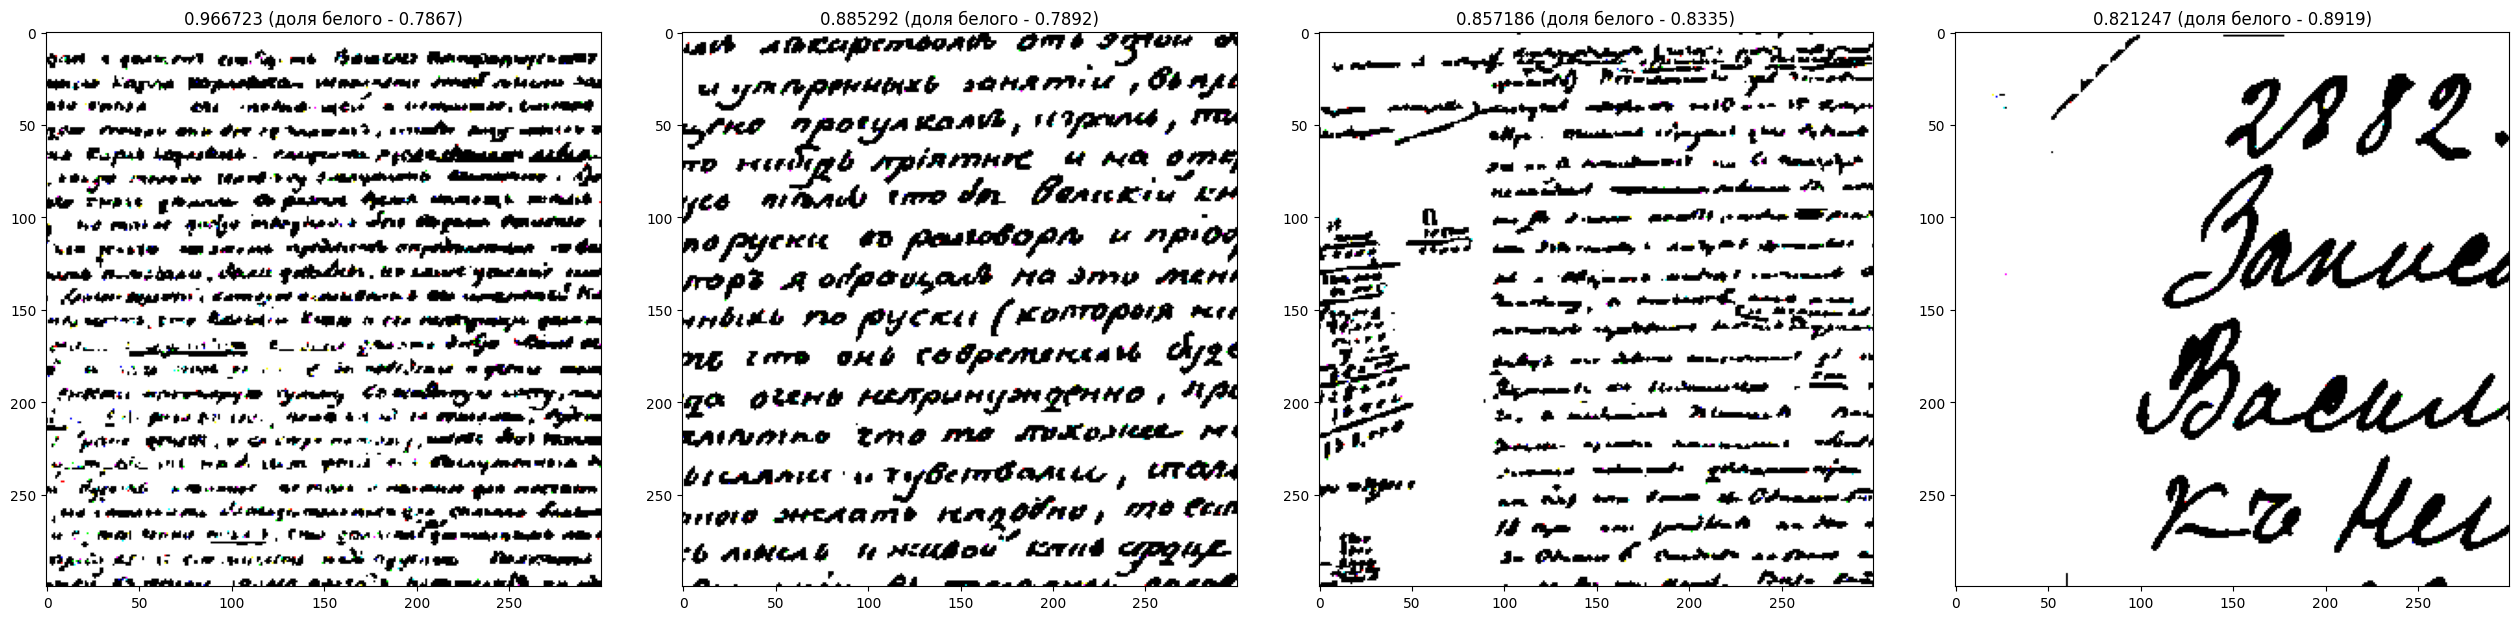

In [30]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.8, greater = True, col = 8)

prob < 0.6
count : 86 out of 242
pic idx : [1, 2, 3, 9, 12, 13, 14, 17]


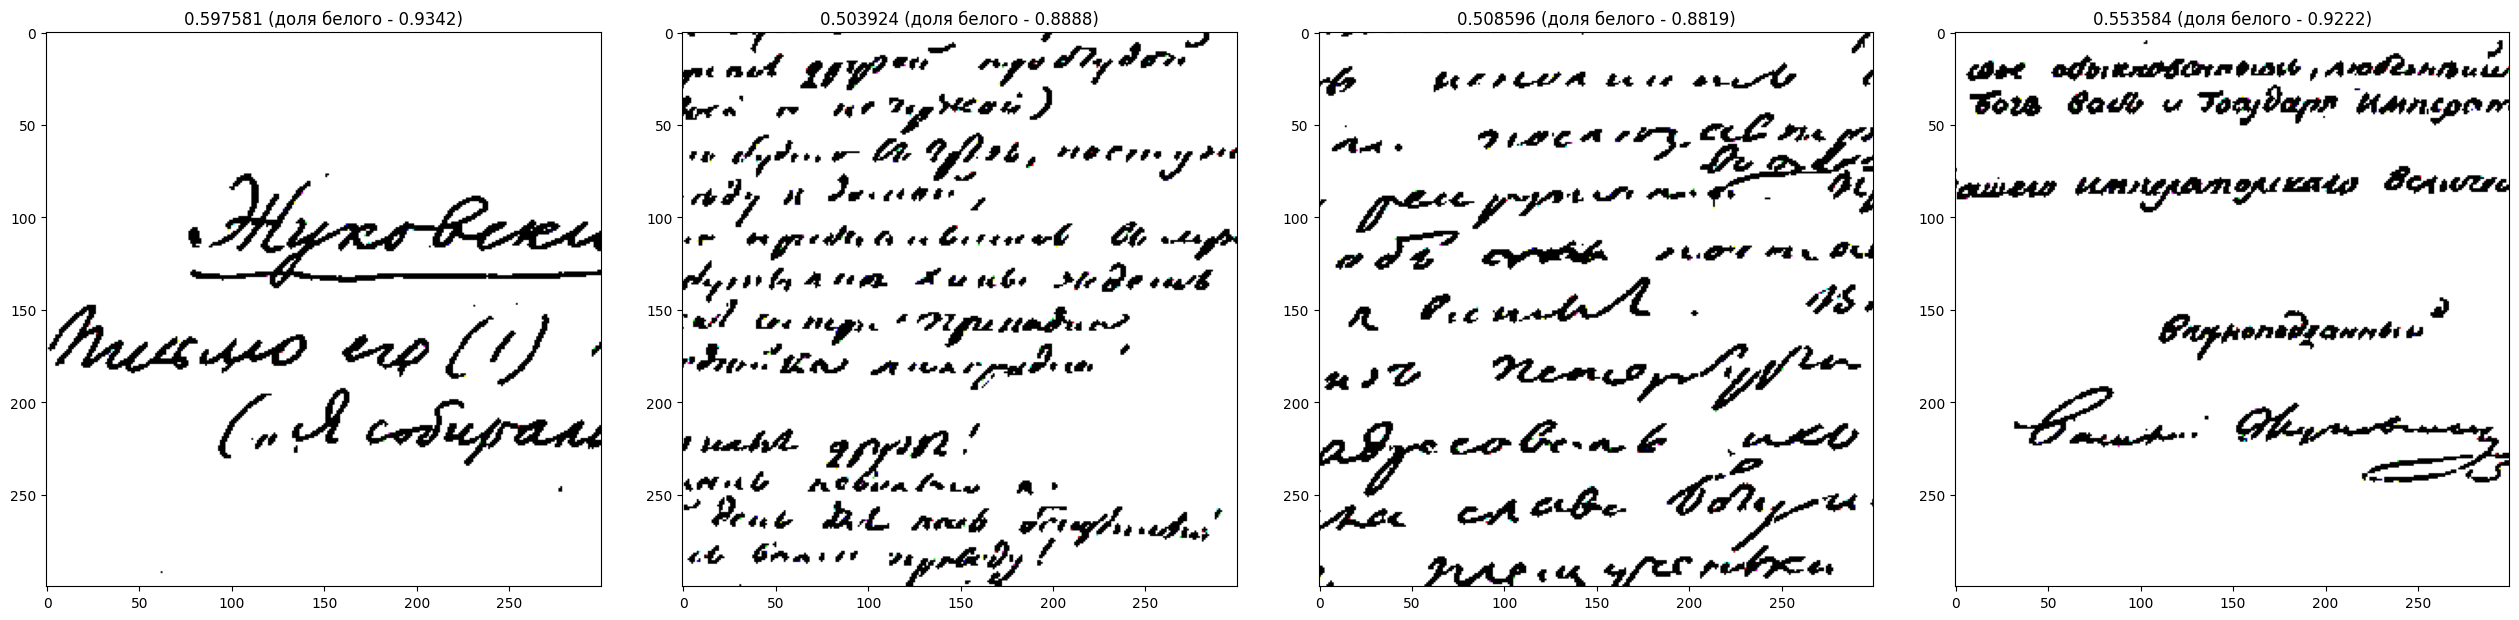

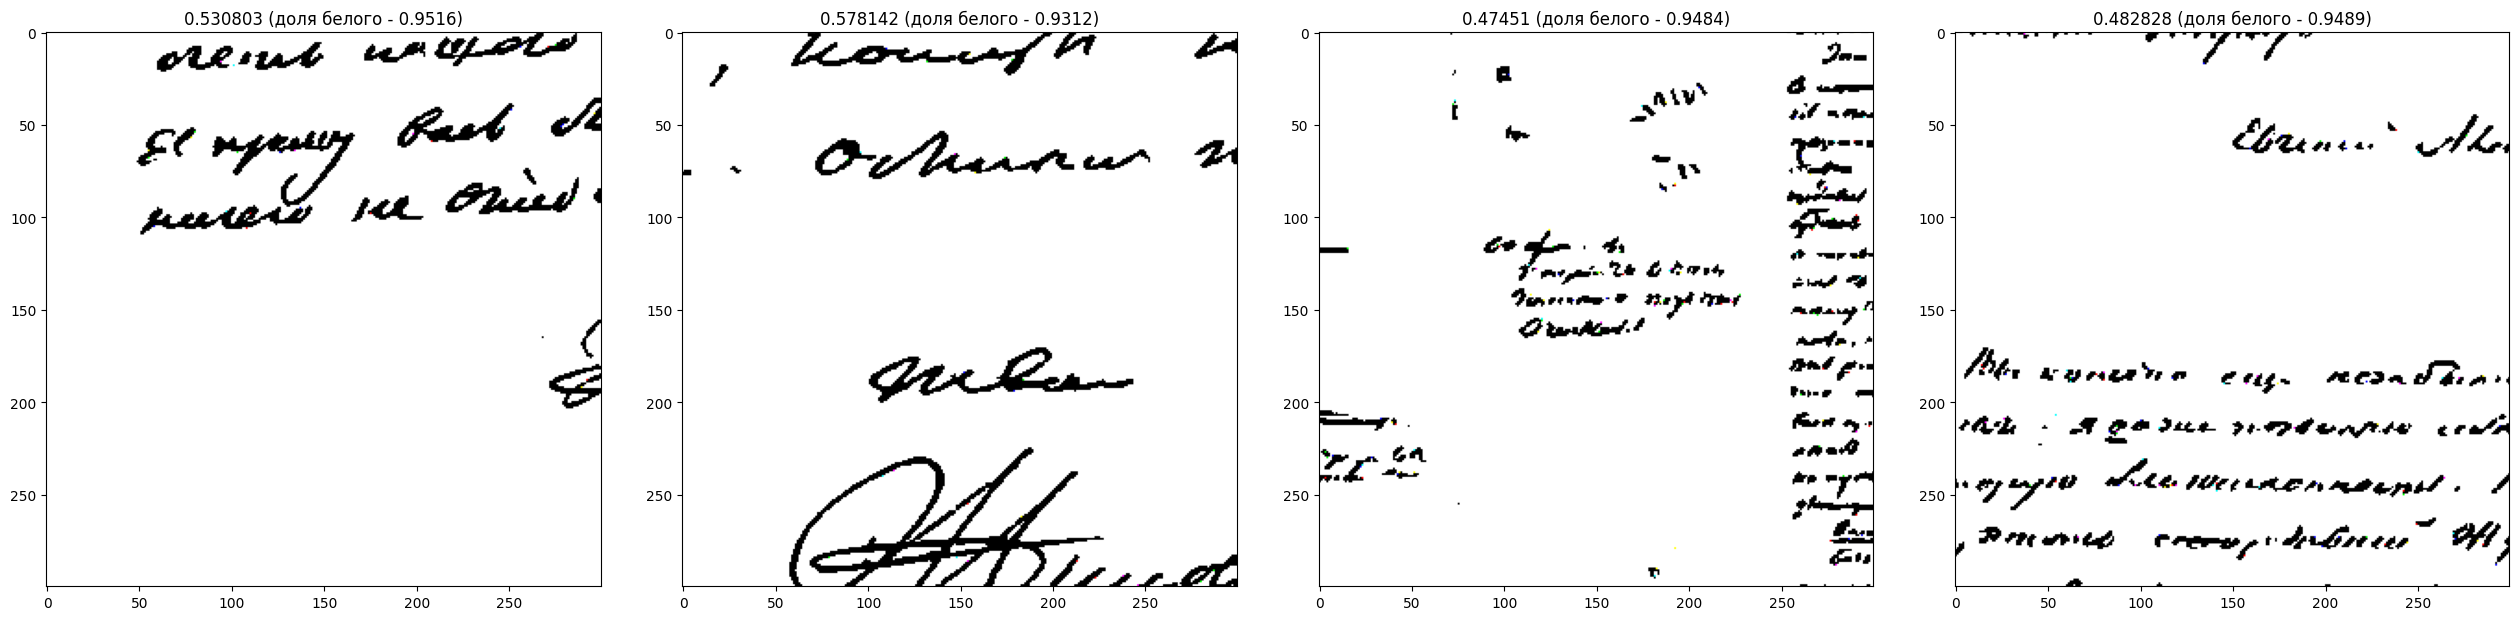

In [31]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.6, greater = False, col = 8)

In [34]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.3, greater = False, col = 24, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.5, greater = True, col = 24)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.6
count : 7 out of 224
pic idx : [25, 36, 128, 143, 184, 206, 213]


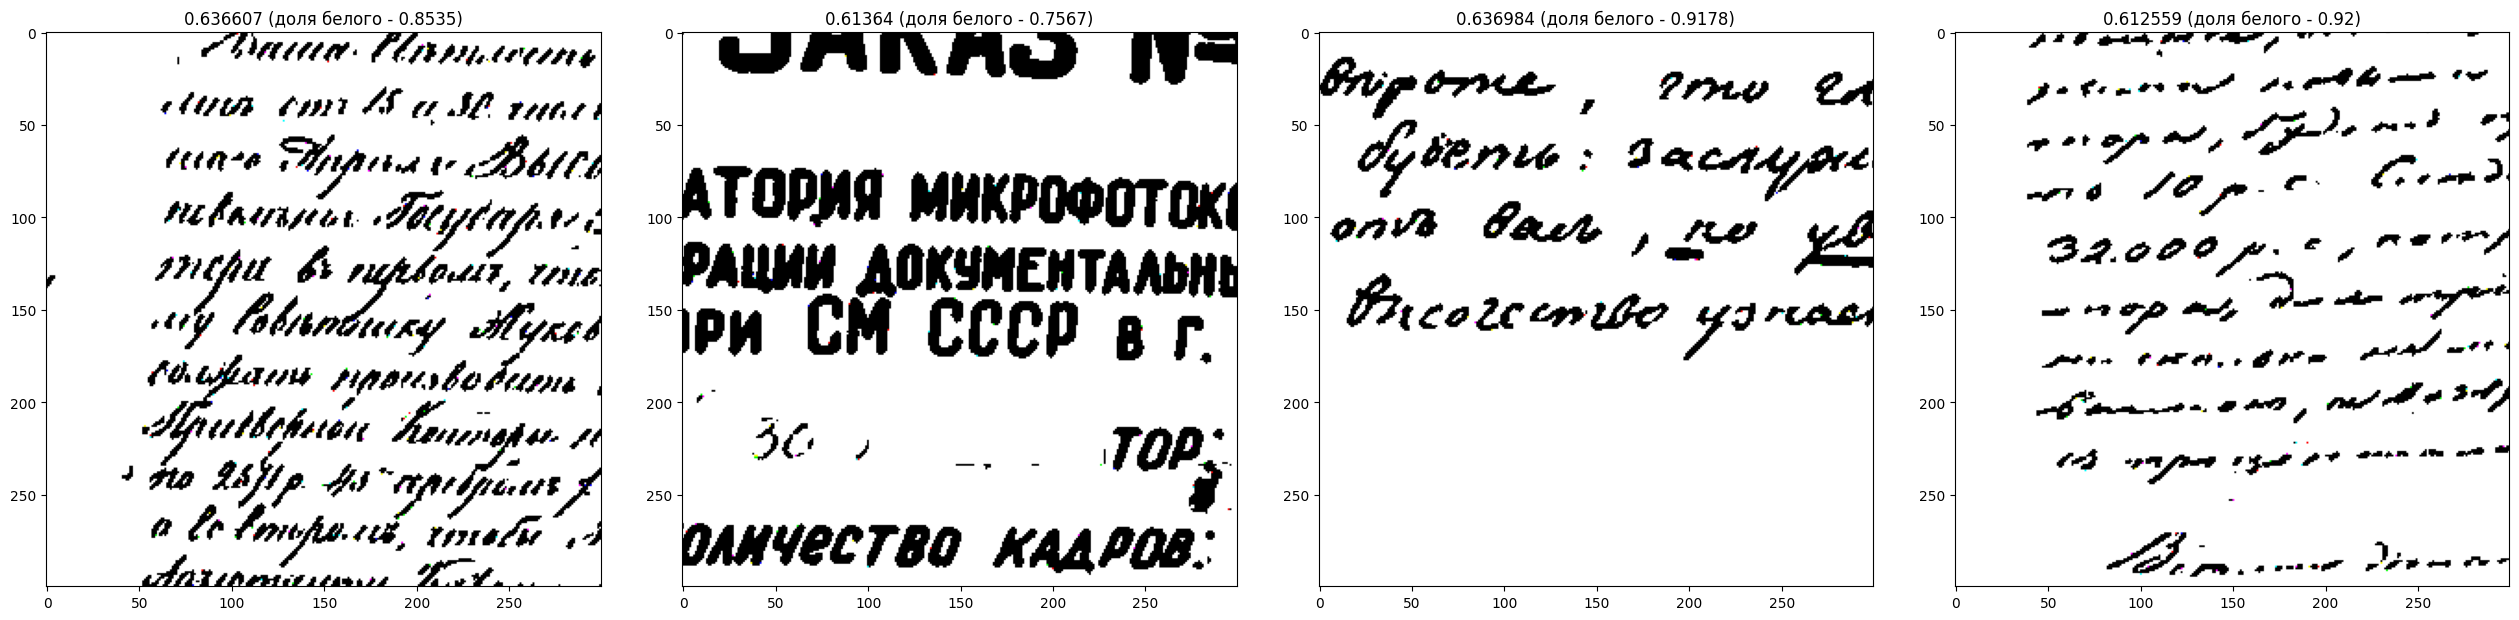

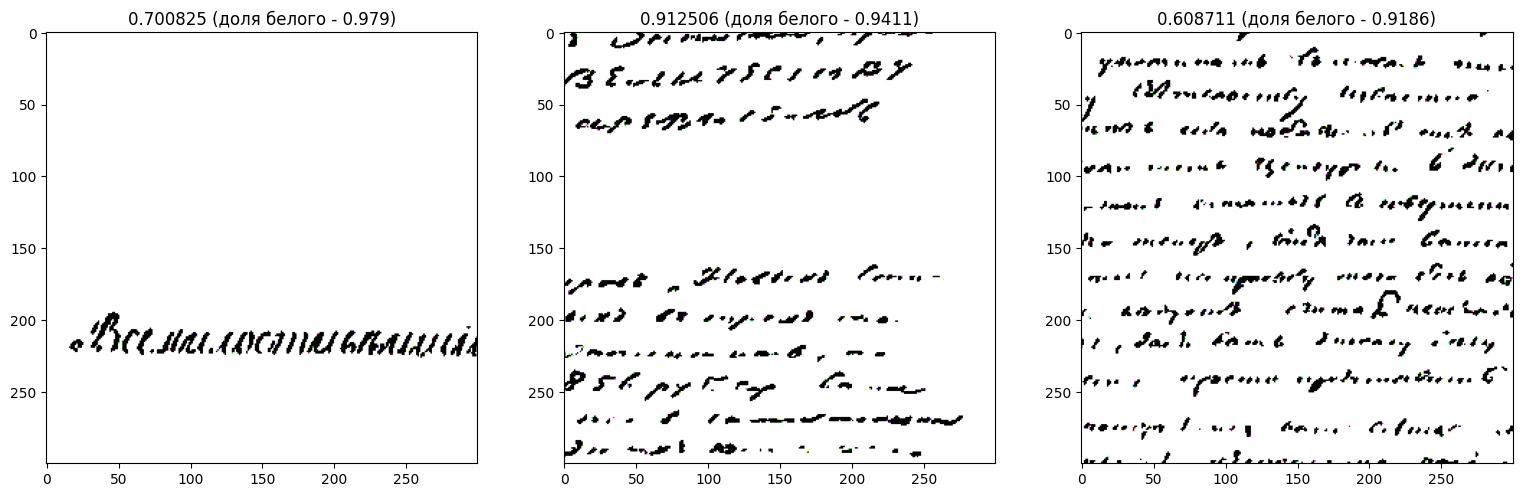

In [36]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.6, greater = True, col = 16, seed = 41)

In [ ]:
# img = pos_dataset[0][0]
# img.shape

In [ ]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [ ]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [ ]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

In [37]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.